In [1]:
import sklearn

In [4]:
from sklearn.isotonic import IsotonicRegression
import pandas as pd
from sklearn.metrics import brier_score_loss
from sklearn.metrics import precision_recall_curve, roc_curve
from pathlib import Path
from sklearn.calibration import calibration_curve
import numpy as np
import matplotlib.pyplot as plt

def get_calibration_model(path):
    # Get results df
    name = "results_.csv"
    results_df = pd.read_csv(Path("../../evaluation/05_results") / path / name)

    # Extract information about true positives vs false postives and plot calibration curve
    all_true = []
    all_predicted = []
    id_cols = sorted([col for col in results_df.columns if col.startswith("id_")])
    for id_col in id_cols[:-1]:
        id = int(id_col.split("_")[1])
        y_true = results_df[f"id_{id}"] == results_df[f"id_{id+1}"]
        y_prob = results_df[f"p{id}_{id+1}"].to_numpy()
        all_predicted = all_predicted + y_prob.tolist()
        all_true = all_true + y_true.tolist()
        #precision_recall_curve(y_true, y_prob)

    model = IsotonicRegression(y_min=0, y_max=1, out_of_bounds="clip", increasing="auto")
    model.fit(all_predicted, all_true)

    return model


In [6]:
import pickle
def store_calibration_model(model, model_path, model_name):
    # Store model via pickle
    pickle.dump(model, open(Path(model_path) / model_name, "wb"))

results_name = "results_.csv"
results_path = "small_mvt_1848"
results = Path("../../evaluation/05_results") / results_path / results_name

# Get calibration model
model = get_calibration_model(results_path)

# Store model
model_path = "../../calibration_models"
model_name = "small_1848.pkl"
store_calibration_model(model, model_path, model_name)

In [2]:
def plot_precision_recall_curve(path, curve="ROC"):
    # Get results df
    name = "results_.csv"
    results_df = pd.read_csv(Path("../../evaluation/05_results") / path / name)

    # Extract information about true positives vs false postives and plot calibration curve
    all_true = []
    all_predicted = []
    id_cols = sorted([col for col in results_df.columns if col.startswith("id_")])
    for id_col in id_cols[:-1]:
        id = int(id_col.split("_")[1])
        y_true = results_df[f"id_{id}"] == results_df[f"id_{id+1}"]
        y_prob = results_df[f"p{id}_{id+1}"].to_numpy()
        all_predicted = all_predicted + y_prob.tolist()
        all_true = all_true + y_true.tolist()
        p, r, t = precision_recall_curve(y_true, y_prob)
        p2, r2, t2 = roc_curve(y_true, y_prob)

        if curve == "ROC":
            plt.plot(r2, p2, label=f"ID {id} vs ID {id+1}")

        elif curve == "PR":
            plt.plot(r, p, label=f"ID {id} vs ID {id+1}")

    if curve == "ROC":
        plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend()

    elif curve == "PR":
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.legend()


    return None

In [3]:
def plot_calibration(path, calibration_model, title="Calibration Plot", frame_shift=0):
    # Prepare fig
    fig, ax = plt.subplots(figsize=(8, 6))

    # Get results df
    name = "results_.csv"
    results_df = pd.read_csv(Path("../../evaluation/05_results") / path / name)

    # Extract information about true positives vs false postives and plot calibration curve
    all_true = []
    all_predicted = []
    id_cols = sorted([col for col in results_df.columns if col.startswith("id_")])
    for id_col in id_cols[:-1]:
        id = int(id_col.split("_")[1])
        y_true = results_df[f"id_{id}"] == results_df[f"id_{id+1}"]
        y_prob = results_df[f"p{id}_{id+1}"].to_numpy()

        # # Calibrate
        if  calibration_model is not None:
            y_prob = calibration_model.transform(y_prob)

        fraction_of_positives, mean_predicted_value = calibration_curve(
            y_true, y_prob, n_bins=8, strategy="uniform"
        )

        print(f'{id}-{id+1}', brier_score_loss(y_true, y_prob))
        all_predicted = all_predicted + y_prob.tolist()
        all_true = all_true + y_true.tolist()
        ax.plot(mean_predicted_value, fraction_of_positives, label=f"{id+frame_shift}-{id+frame_shift+1}")

    # Only 3 decimal places
    bs = brier_score_loss(all_true, all_predicted)
    bs = round(bs, 3)
    textstr = f'Total BS = {bs}'
    
    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='grey', alpha=0.2)

    # place a text box in upper left in axes coords
    ax.text(0.03, 0.68, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)

    # Get total brier score
    bs = brier_score_loss(all_true, all_predicted)
    print("Total brier score:", bs)

    # Get counts in bins
    counts, bins = np.histogram(all_predicted, bins=15)

    # Plot perfect calibration line
    ax.plot([0, 1], [0, 1], "k:", label="Perfectly Calibrated")

    # Normalize
    counts = (15/10)*counts / len(all_predicted)

    # plot
    ax.plot(bins[1:], counts, label="Probability Distribution", linestyle="--", color="grey")
    ax.fill_between(bins[1:], counts, 0, color='grey', alpha=.1)

    # Add legend and save plot
    ax.set_ylabel("Observation", fontsize=13)
    ax.set_xlabel("Prediction", fontsize=13)

    # Make ticks smaller
    ax.tick_params(axis='both', which='both', labelsize=14)

    # Put probability distribution label for last plot on top
    handles, labels = ax.get_legend_handles_labels()
    handles = handles[-2:] + handles[:-2]
    labels = labels[-2:] + labels[:-2]

    ax.legend(handles, labels, fontsize=12, loc="upper left")
    ax.set_title(title, fontweight="bold", fontsize=14)


    fig.savefig("calibration_plot.png")


0-1 0.15599573200809866
1-2 0.14532465046935394
2-3 0.12180764329099943
Total brier score: 0.1410426752561507


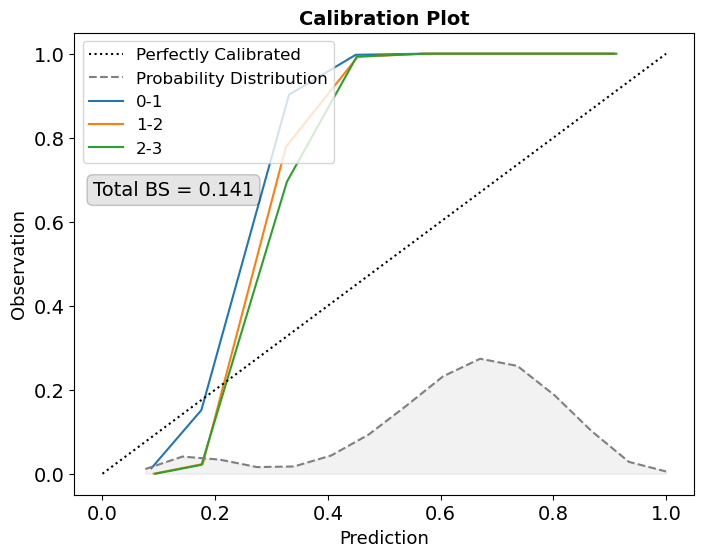

In [17]:
plot_calibration("large_mvt_6000", calibration_model=None)

0-1 0.011891348351239924
1-2 0.017032459190232392
2-3 0.016902846631399415
Total brier score: 0.015275551390957244


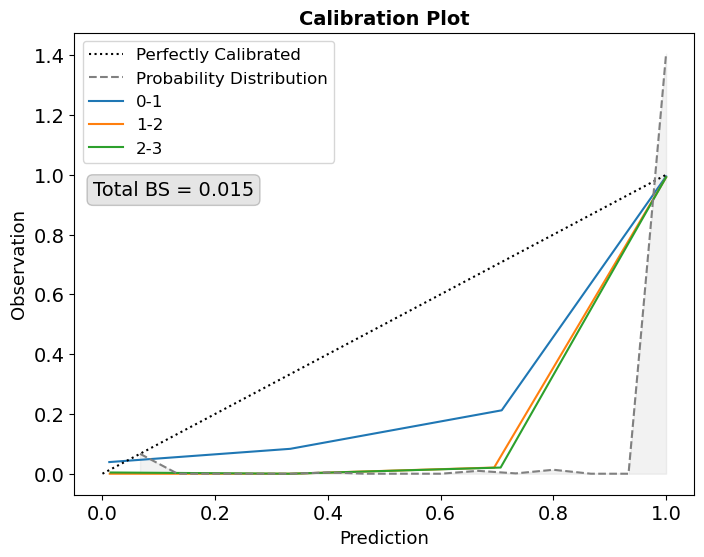

In [18]:
calibration_model = get_calibration_model("medium_mvt_6000")
plot_calibration("large_mvt_6000", calibration_model=calibration_model)

0-1 0.007844917045117488
1-2 0.005163383989819084
2-3 0.004313081181098449
Total brier score: 0.005773794072011674


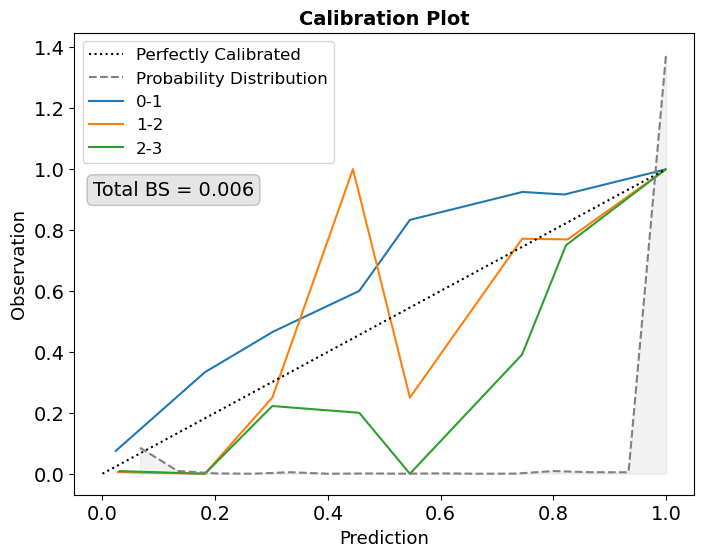

In [19]:
#ranks
calibration_model = get_calibration_model("large_mvt_6000")
plot_calibration("large_mvt_6000", calibration_model=calibration_model)

0-1 0.011891348351239924
1-2 0.017032459190232392
2-3 0.016902846631399415
Total brier score: 0.015275551390957244


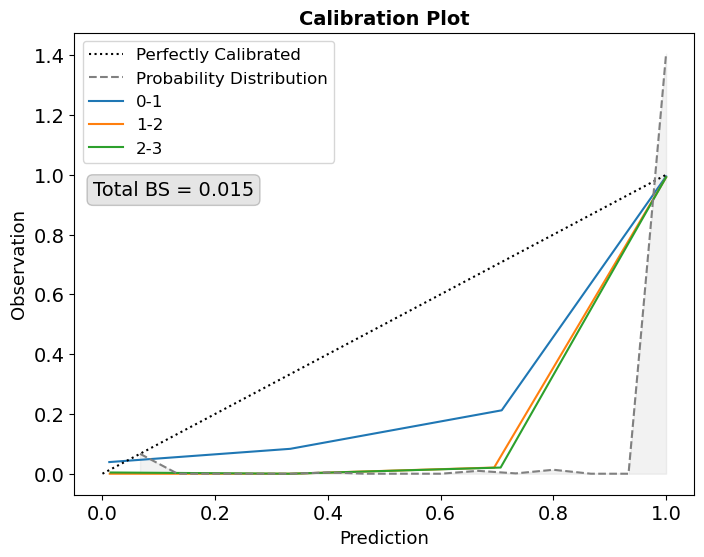

In [20]:
calibration_model = get_calibration_model("medium_mvt_6000")
plot_calibration("large_mvt_6000", calibration_model=calibration_model)

0-1 0.011891348351239924
1-2 0.017032459190232392
2-3 0.016902846631399415
Total brier score: 0.015275551390957244


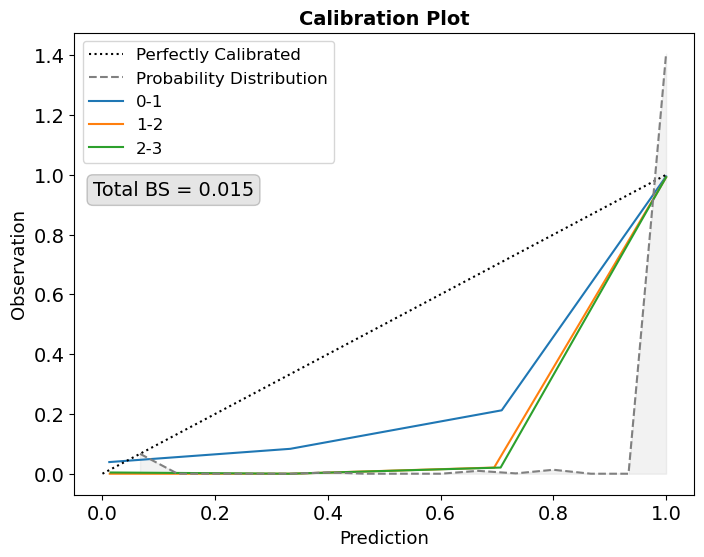

In [21]:
#ranks
calibration_model = get_calibration_model("medium_mvt_6000")
plot_calibration("large_mvt_6000", calibration_model=calibration_model)

/home/mike/anaconda3/envs/eth_dsl/lib/python3.9/site-packages/sklearn/isotonic.py:70: UserWarning: Confidence interval of the Spearman correlation coefficient spans zero. Determination of ``increasing`` may be suspect.
  warnings.warn(


0-1 0.04736259666009957
1-2 0.06839319840117435
2-3 0.0664866965253492
Total brier score: 0.06074749719554103


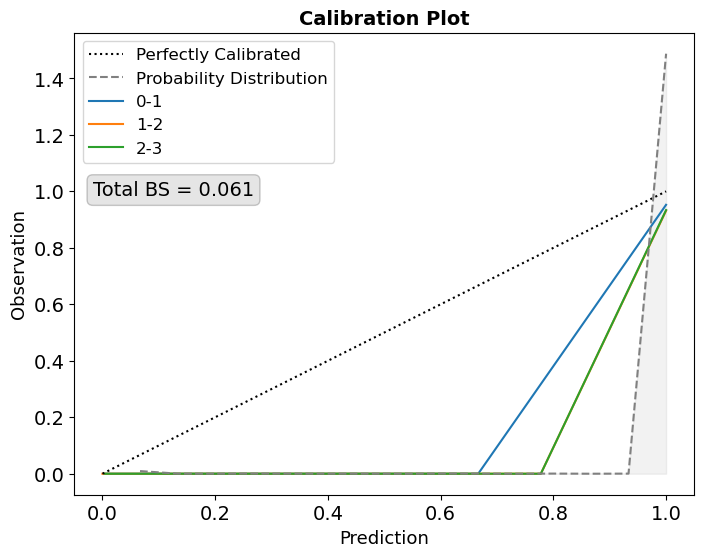

In [22]:
calibration_model = get_calibration_model("small_mvt_6000")
plot_calibration("large_mvt_6000", calibration_model=calibration_model)

/home/mike/anaconda3/envs/eth_dsl/lib/python3.9/site-packages/sklearn/isotonic.py:70: UserWarning: Confidence interval of the Spearman correlation coefficient spans zero. Determination of ``increasing`` may be suspect.
  warnings.warn(


0-1 0.04736259666009957
1-2 0.06839319840117435
2-3 0.0664866965253492
Total brier score: 0.06074749719554103


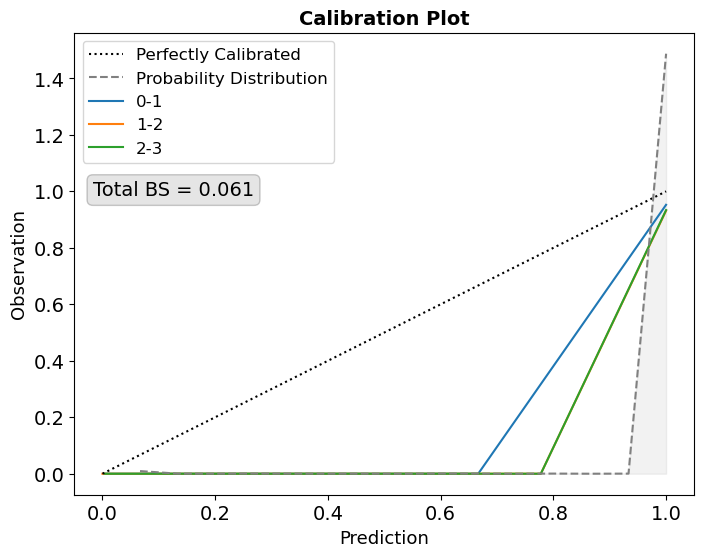

In [23]:
#ranks
calibration_model = get_calibration_model("small_mvt_6000")
plot_calibration("large_mvt_6000", calibration_model=calibration_model)

0-1 0.08254295039257672
1-2 0.09149832994289792
2-3 0.07895297858672377
Total brier score: 0.0843314196407328


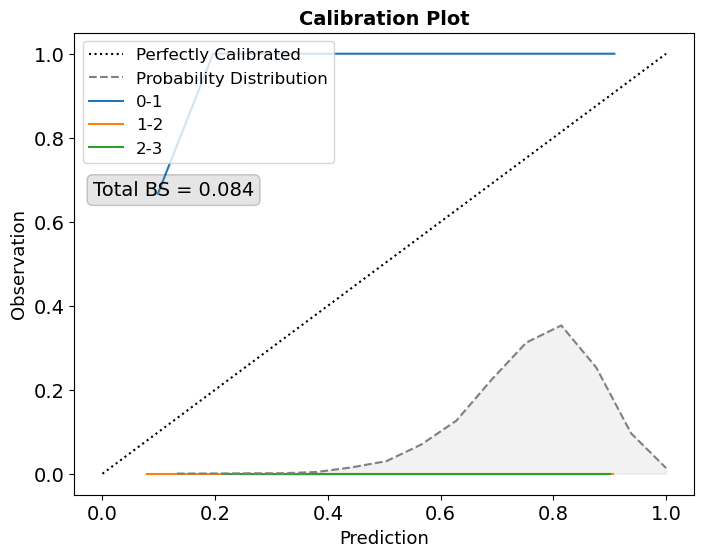

In [24]:
plot_calibration("small_mvt_6000", calibration_model=None)

0-1 0.2988609535165723
1-2 0.2765941734033953
2-3 0.2861906313662086
Total brier score: 0.2872152527620587


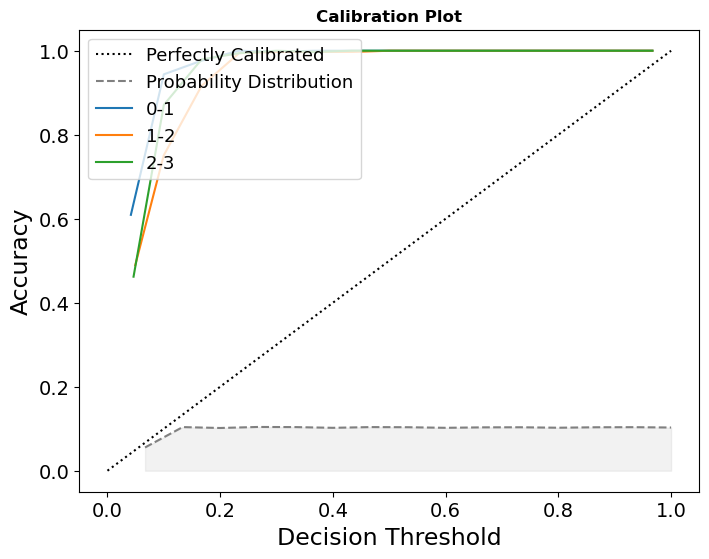

In [33]:
#ranks
plot_calibration("small_mvt_6000", calibration_model=None)

0-1 0.023332034750013417
1-2 0.03170855101983801
2-3 0.027666946213410565
Total brier score: 0.027569177327753998


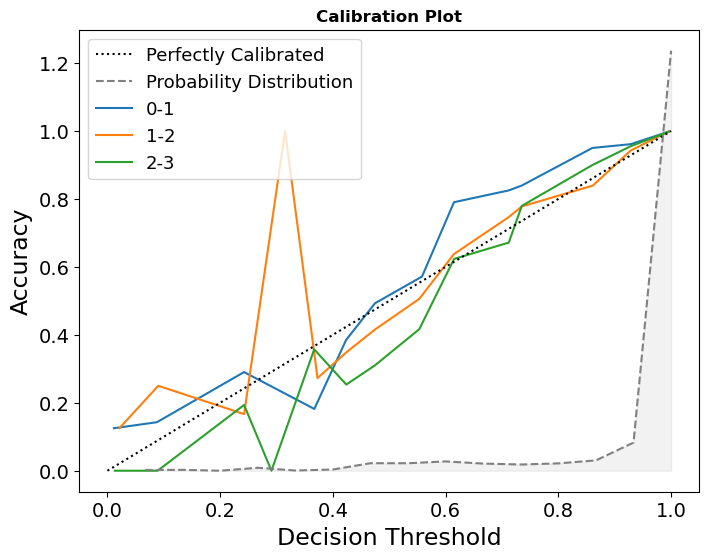

In [ ]:
calibration_model = get_calibration_model("small_mvt_6000")
plot_calibration("medium_mvt_6000", calibration_model=calibration_model)

0-1 0.028535746449341714
1-2 0.053000820926470384
2-3 0.04250386499648222
Total brier score: 0.041346810790764764


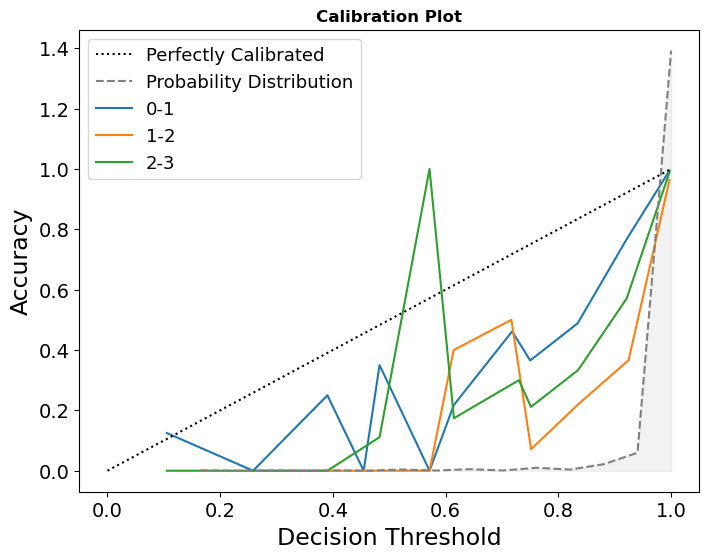

In [35]:
#ranks
calibration_model = get_calibration_model("small_mvt_6000")
plot_calibration("medium_mvt_6000", calibration_model=calibration_model)

0-1 0.09539240501071813
1-2 0.09229166318327973
2-3 0.08459103697749197
Total brier score: 0.09075836839049661


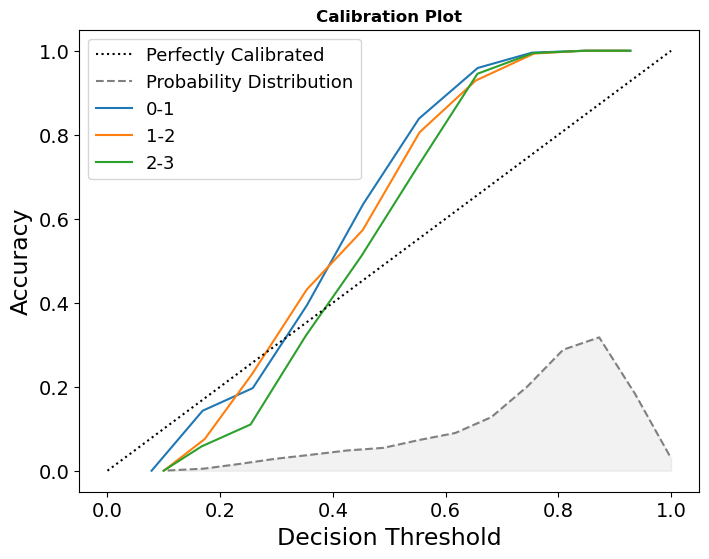

In [7]:
#ranks
# calibration_model = get_calibration_model("medium_mvt_20000")
plot_calibration("medium_mvt_20000", calibration_model=None)

0-1 0.04727488625065925
1-2 0.05195408834258857
2-3 0.04904769186612483
Total brier score: 0.04942555548645756


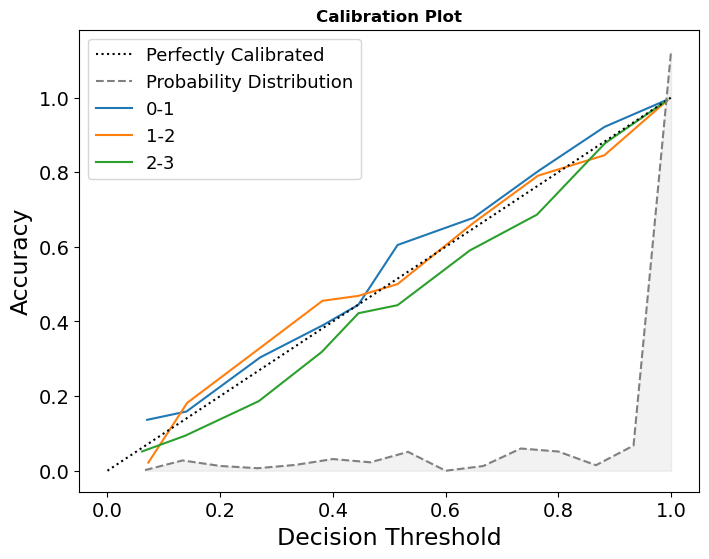

In [8]:
#ranks
calibration_model = get_calibration_model("medium_mvt_20000")
plot_calibration("medium_mvt_20000", calibration_model=calibration_model)

0-1 0.12100191643727881
1-2 0.1309204968541093
2-3 0.11779671293747543
Total brier score: 0.12323970874295452


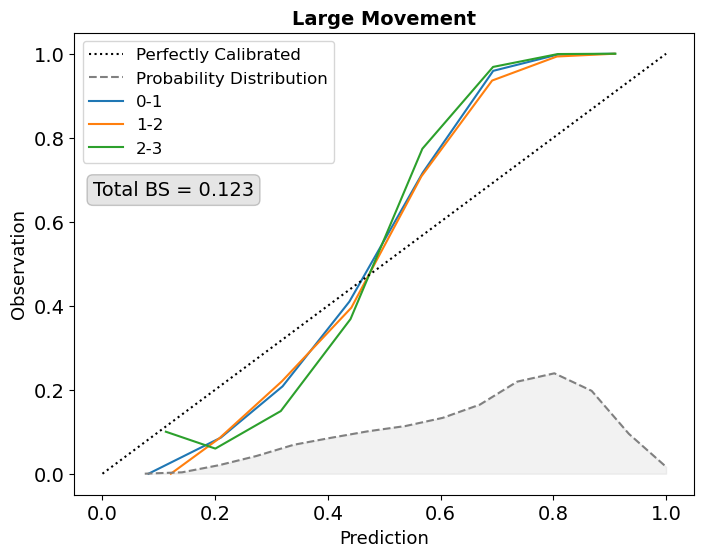

In [97]:
#ranks
# calibration_model = get_calibration_model("medium_mvt_20000")
plot_calibration("large_mvt_20000", calibration_model=None, title="Large Movement")

0-1 0.08955593011826517
1-2 0.10611752588610238
2-3 0.08447281380192728
Total brier score: 0.09338208993543161


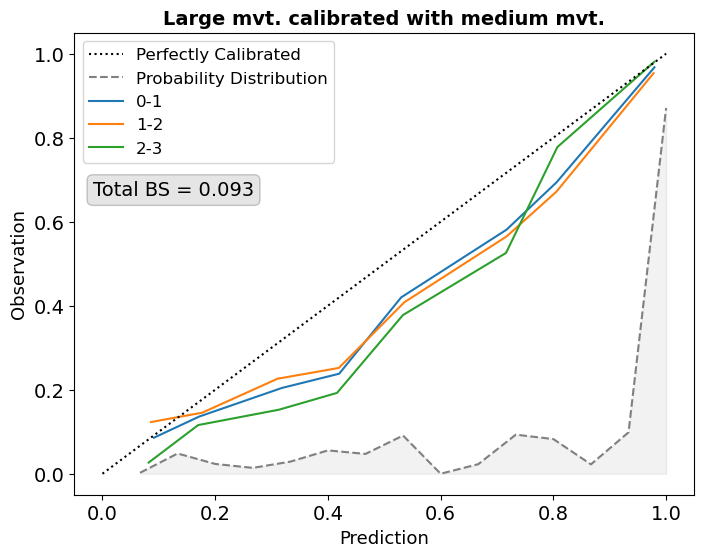

In [102]:
#ranks
calibration_model = get_calibration_model("medium_mvt_20000")
plot_calibration("large_mvt_20000", calibration_model=calibration_model, title="Large mvt. calibrated with medium mvt.")

0-1 0.053409336183506434
1-2 0.05733907530527652
2-3 0.04960169670687109
Total brier score: 0.053450036065218025


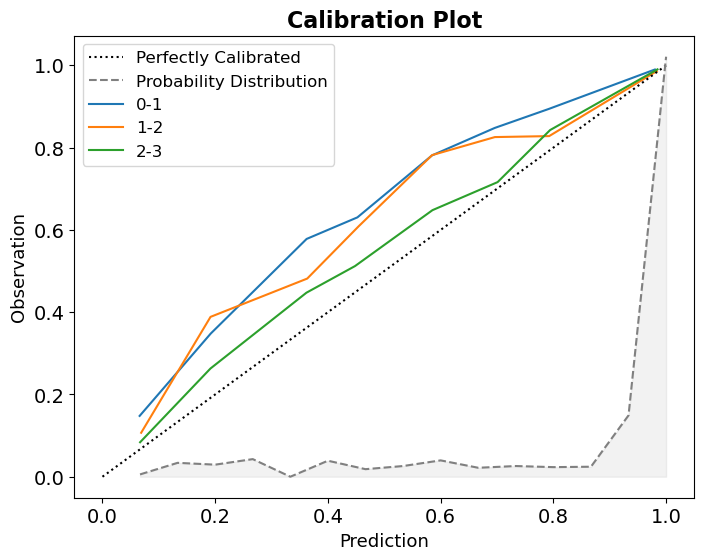

In [63]:
#ranks
calibration_model = get_calibration_model("large_mvt_20000")
plot_calibration("medium_mvt_20000", calibration_model=calibration_model)

0-1 0.07629037694104714
1-2 0.07461094379552013
2-3 0.06533445320873986
Total brier score: 0.07207859131510237


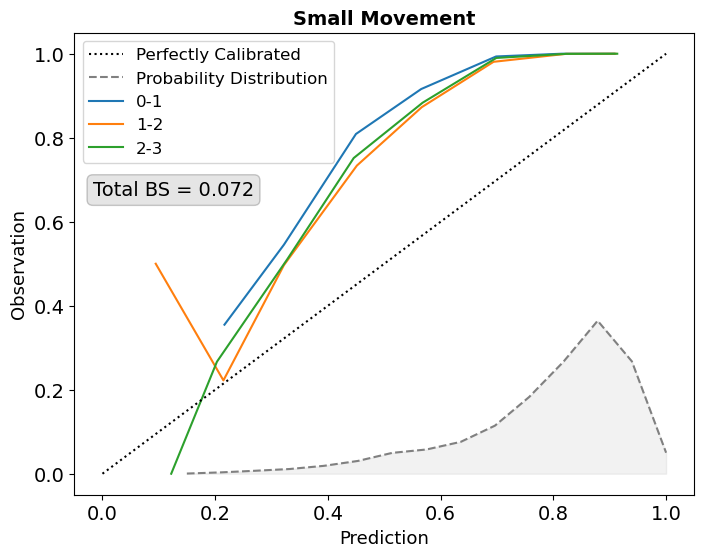

In [103]:
#ranks
plot_calibration("small_mvt_20000", calibration_model=None, title="Small Movement")

0-1 0.09539240501071813
1-2 0.09229166318327973
2-3 0.08459103697749197
Total brier score: 0.09075836839049661


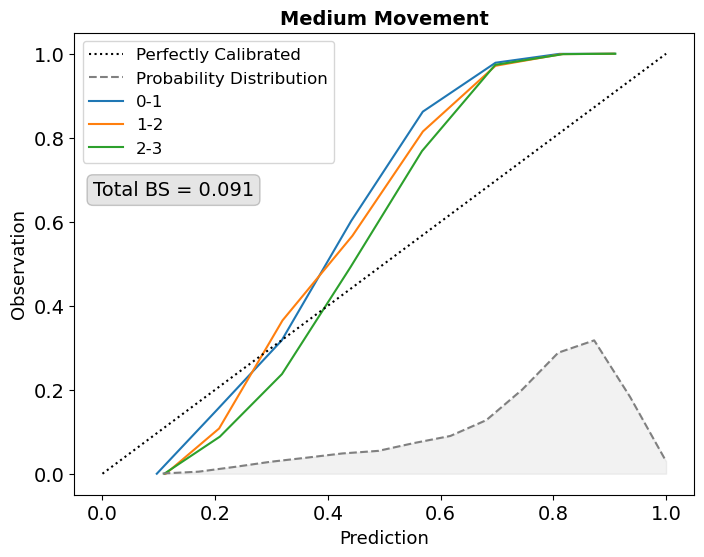

In [104]:
#ranks
plot_calibration("medium_mvt_20000", calibration_model=None, title="Medium Movement")

0-1 0.12100191643727881
1-2 0.1309204968541093
2-3 0.11779671293747543
Total brier score: 0.12323970874295452


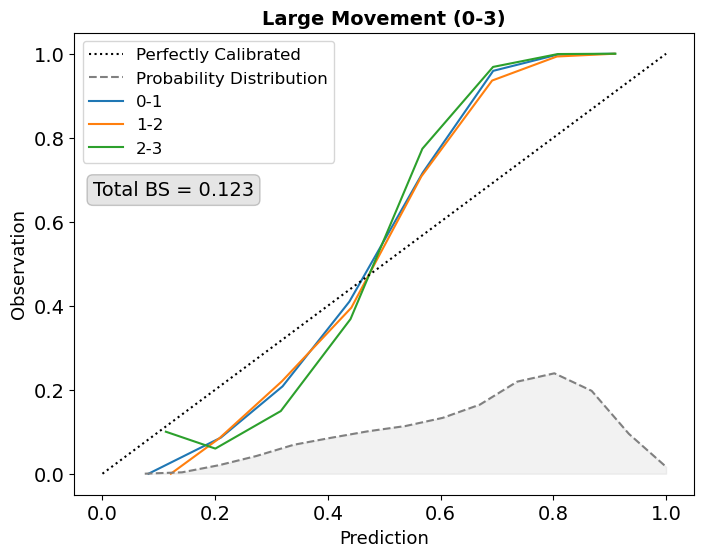

In [139]:
#ranks
plot_calibration("large_mvt_20000", calibration_model=None, title="Large Movement (0-3)")

0-1 0.02521232683768149
1-2 0.033849946971202145
2-3 0.025971049084555265
Total brier score: 0.028344440964479627


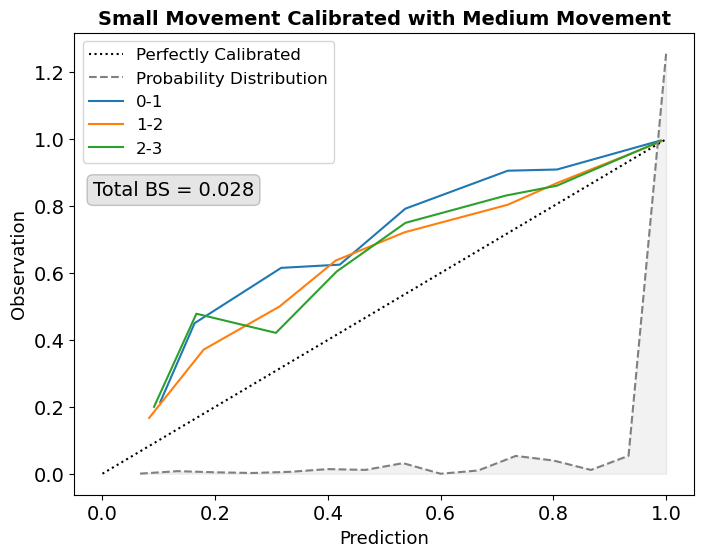

In [94]:
#ranks
calibration_model = get_calibration_model("medium_mvt_20000")
plot_calibration("small_mvt_20000", calibration_model=calibration_model, title="Small Movement Calibrated with Medium Movement")

0-1 0.07629037694104714
1-2 0.07461094379552013
2-3 0.06533445320873986
Total brier score: 0.07207859131510237


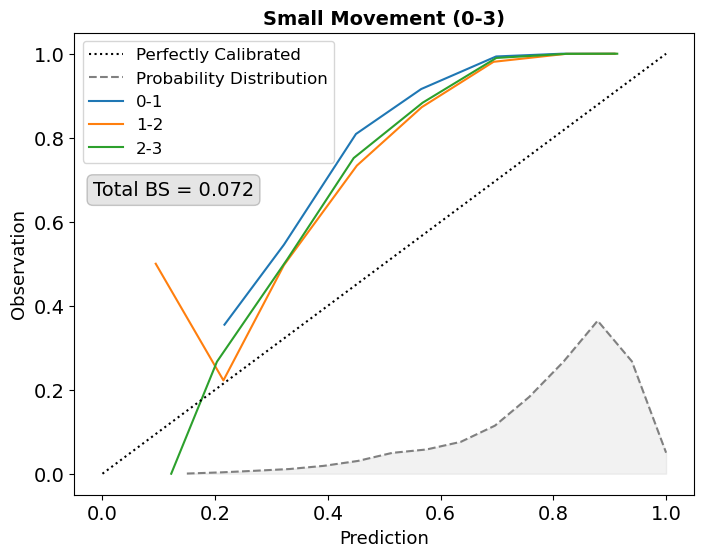

In [136]:
#ranks
calibration_model = get_calibration_model("small_mvt_20000")
plot_calibration("small_mvt_20000", calibration_model=None, title="Small Movement (0-3)")

0-1 0.08453940266311585
1-2 0.09838204540612518
2-3 0.0962286758988016
Total brier score: 0.09305004132268087


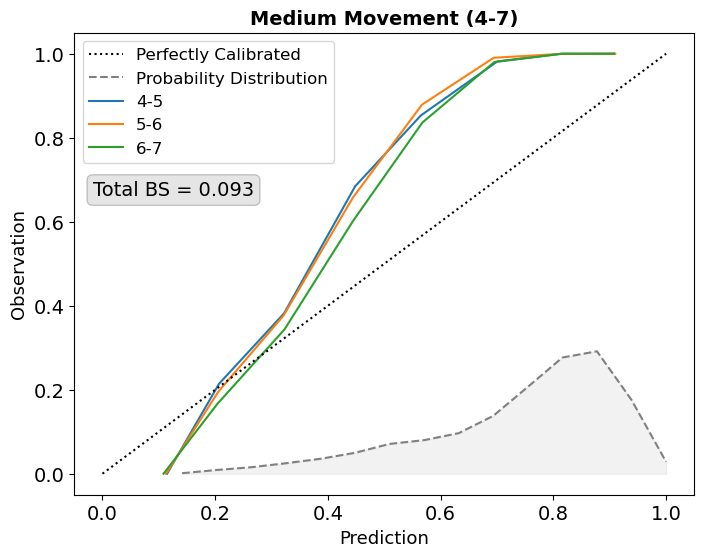

In [117]:
#ranks
plot_calibration("medium_mvt_20000_frames_2345", calibration_model=None, title="Medium Movement (4-7)", frame_shift=4)

0-1 0.09539240501071813
1-2 0.09229166318327973
2-3 0.08459103697749197
Total brier score: 0.09075836839049661


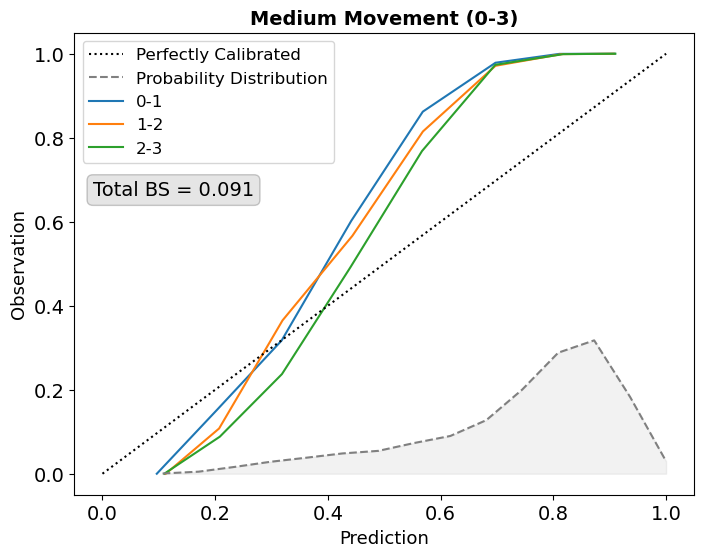

In [130]:
#ranks
plot_calibration("medium_mvt_20000", calibration_model=None, title="Medium Movement (0-3)", frame_shift=0)

0-1 0.039231537460588786
1-2 0.04974403865351199
2-3 0.05258835910821817
Total brier score: 0.04718797840743964


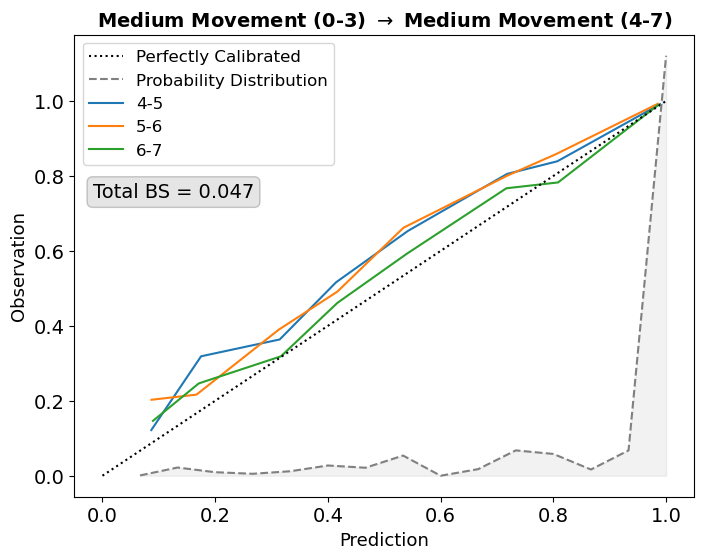

In [133]:
#ranks
calibration_model = get_calibration_model("medium_mvt_20000")
plot_calibration("medium_mvt_20000_frames_2345", calibration_model=calibration_model, frame_shift=4, title="Medium Movement (0-3) " + r'$\rightarrow$ Medium Movement (4-7)')

0-1 0.08955593011826517
1-2 0.10611752588610238
2-3 0.08447281380192728
Total brier score: 0.09338208993543161


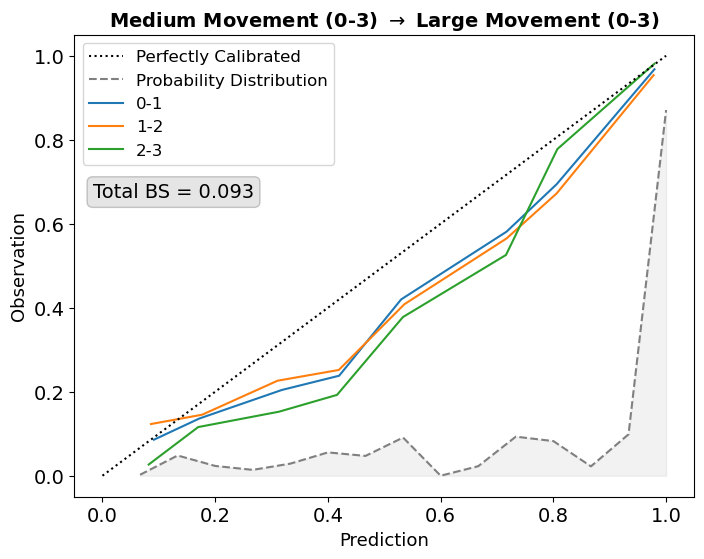

In [137]:
#ranks
calibration_model = get_calibration_model("medium_mvt_20000")
plot_calibration("large_mvt_20000", calibration_model=calibration_model, frame_shift=0, title="Medium Movement (0-3) " + r'$\rightarrow$ Large Movement (0-3)')

0-1 0.02521232683768149
1-2 0.033849946971202145
2-3 0.025971049084555265
Total brier score: 0.028344440964479627


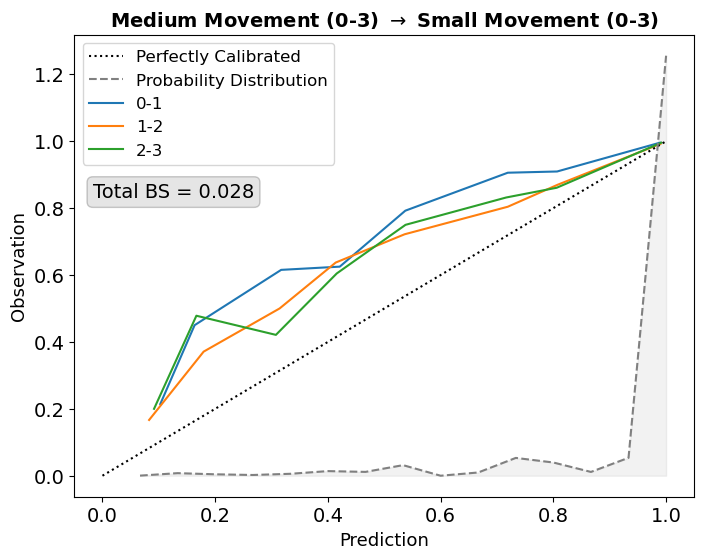

In [140]:
#ranks
calibration_model = get_calibration_model("medium_mvt_20000")
plot_calibration("small_mvt_20000", calibration_model=calibration_model, frame_shift=0, title="Medium Movement (0-3) " + r'$\rightarrow$ Small Movement (0-3)')